In [1]:
!pip install gitpython

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.0/190.0 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 6.7 MB/s eta 0:00:00


In [2]:
import git
repo_url = 'https://github.com/Pedro1043/dataFiltrada'
#Directorio en donde se clonara el repo
dest_directory = "/content/repo"
#Clonar el repo
repo = git.Repo.clone_from(repo_url, dest_directory)  #SOLO SE TIENE QUE EJECUTAR UNA VEZ

In [ ]:
# Importamos las bibliotecas necesarias
import os
import json
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [ ]:
# 1. Verificar la data github
data_path2 = '/content/repo/dataFiltrada'
images_path = os.path.join(data_path2, "images")
annotations_path = os.path.join(data_path2, "annotations", "instances.json")

# Asegurándonos de que las imágenes y anotaciones existen
if not os.path.exists(images_path) or not os.path.exists(annotations_path):
    raise ValueError("La ruta de imágenes o anotaciones no existe.")

# Cargamos las anotaciones
with open(annotations_path, 'r') as file:
    annotations = json.load(file)

# Filtramos las imágenes que no tienen etiquetas
filtered_images = [item['file_name'] for item in annotations['images'] if item['id'] in [anno['image_id'] for anno in annotations['annotations']]]

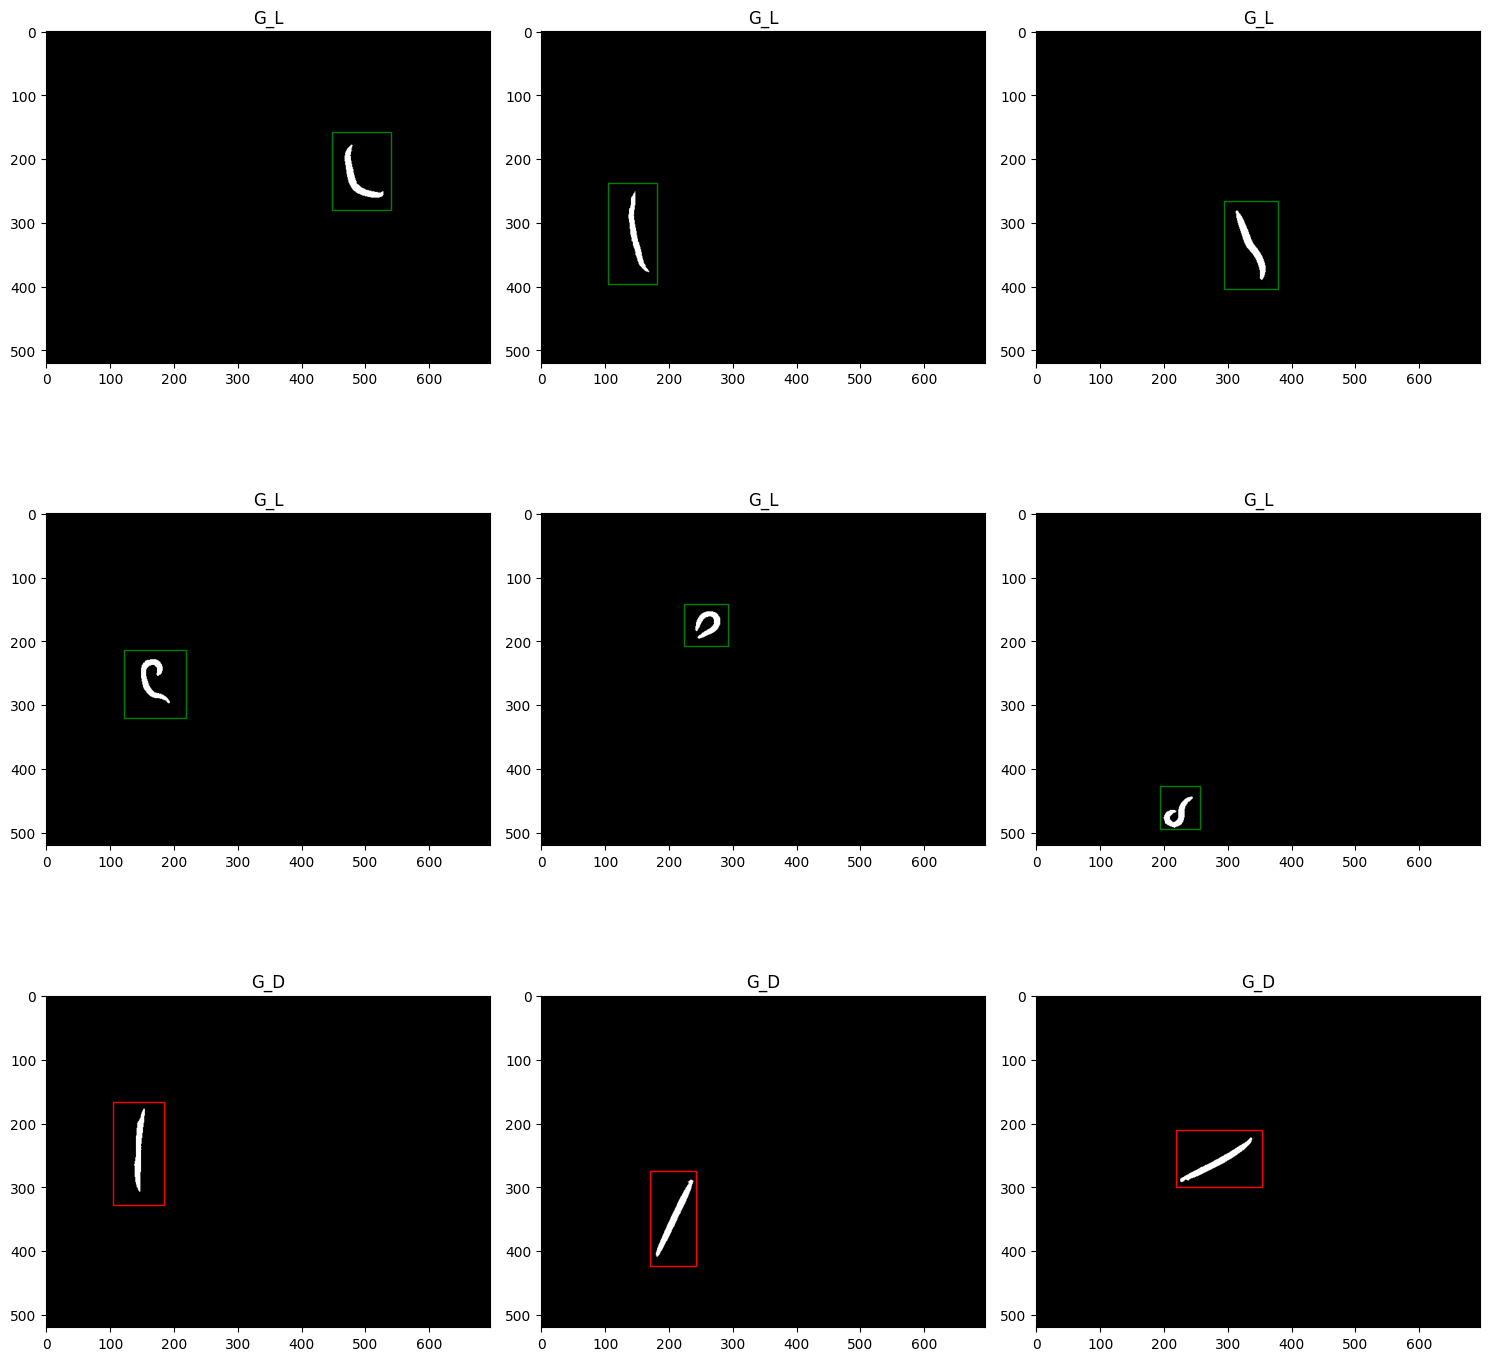

In [ ]:
#Nota : solo para visualizar la data ontenido

#Volver a correr el programa y santando este grupo de codigos hasta la parte 2 de normalizacion
annotations_path = os.path.join(data_path2, 'annotations', 'instances.json')

with open(annotations_path, 'r') as f:
    coco_data = json.load(f)

# Mapeo de ID a nombre de categoría
id_to_name = {category['id']: category['name'] for category in coco_data['categories']}
# Selecciona las primeras 9 imágenes
images = coco_data['images'][:9]
fig, axs = plt.subplots(3, 3, figsize=(15, 15))

for ax, img_data in zip(axs.ravel(), images):
    img_path = os.path.join(data_path2, 'images', img_data['file_name'])
    img = load_img(img_path)  # Carga la imagen
    ax.imshow(img)

    # Encuentra las anotaciones de la imagen y muestra las etiquetas
    annotations = [ann for ann in coco_data['annotations'] if ann['image_id'] == img_data['id']]

    labels = [id_to_name[ann['category_id']] for ann in annotations]

    ax.set_title(", ".join(labels))

    # Visualizar los bounding boxes (cajas delimitadoras)
    for ann in annotations:

        bbox = ann['bbox']
        category_id = ann['category_id']

        if category_id == 2:
           rect = plt.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], fill=False,edgecolor='red')
        if category_id == 1:
          rect = plt.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], fill=False,edgecolor='green')
        ax.add_patch(rect)

plt.tight_layout()
plt.show()

In [ ]:
# 2. Normalizar la data
img_size = (150, 150)  # Cambiamos el tamaño de las imágenes a 150x150 para simplificar
data = []
labels = []

for image_name in filtered_images:
    img_path = os.path.join(images_path, image_name)
    img = load_img(img_path, target_size=img_size)
    img_array = img_to_array(img) / 255.0
    data.append(img_array)

    # Obtener la etiqueta de la imagen
    image_id = [item['id'] for item in annotations['images'] if item['file_name'] == image_name][0]
    category_id = [anno['category_id'] for anno in annotations['annotations'] if anno['image_id'] == image_id][0]
    labels.append(category_id - 1)  # Restamos 1 para que las etiquetas sean 0 y 1

data = np.array(data)
labels = np.array(labels)

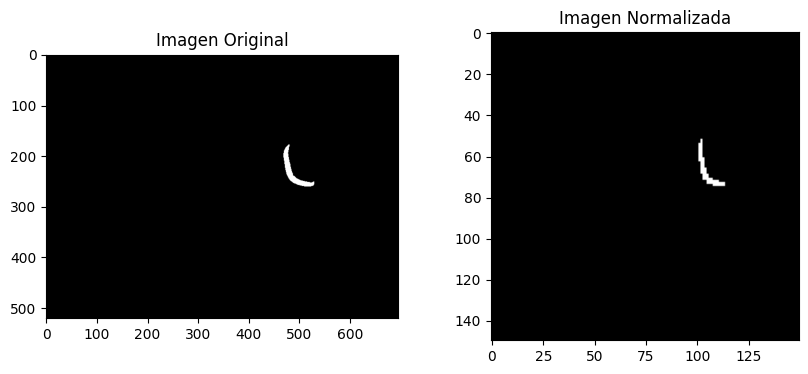

In [ ]:
# 3. Comparar la data original con la normalizada
original_img = load_img(os.path.join(images_path, filtered_images[0]))
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(original_img)
plt.title("Imagen Original")
plt.subplot(1, 2, 2)
plt.imshow(data[0])
plt.title("Imagen Normalizada")
plt.show()

In [ ]:

# 4. Dividir la data en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

# 5. Crear una red convolucional simple
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(2, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# 6. Entrenar el modelo
model.fit(X_train, y_train, epochs=5, validation_data=(X_test, y_test))

# 7. Predecir el resultado
test_image_path = "/content/prueba.png"
test_img = load_img(test_image_path, target_size=img_size)
test_img_array = img_to_array(test_img) / 255.0
test_img_array = np.expand_dims(test_img_array, axis=0)

predictions = model.predict(test_img_array)
predicted_class = np.argmax(predictions, axis=1)

if predicted_class[0] == 0:
    print("La imagen es de tipo G_L.")
else:
    print("La imagen es de tipo G_D.")


Epoch 1/5
36/36 [==============================] - 80s 2s/step - loss: 0.6985 - accuracy: 0.5357 - val_loss: 0.6855 - val_accuracy: 0.5374
Epoch 2/5
36/36 [==============================] - 78s 2s/step - loss: 0.6180 - accuracy: 0.6702 - val_loss: 0.6966 - val_accuracy: 0.5409
Epoch 3/5
36/36 [==============================] - 74s 2s/step - loss: 0.4208 - accuracy: 0.8235 - val_loss: 0.9554 - val_accuracy: 0.5374
Epoch 4/5
36/36 [==============================] - 74s 2s/step - loss: 0.1670 - accuracy: 0.9394 - val_loss: 1.3712 - val_accuracy: 0.5765
Epoch 5/5
1/1 [==============================] - 0s 126ms/step
La imagen es de tipo G_L.


In [ ]:
# 7. Predecir el resultado 1
test_image_path = "/content/repo/carpetasPrueba/prueba.png"
test_img = load_img(test_image_path, target_size=img_size)
test_img_array = img_to_array(test_img) / 255.0
test_img_array = np.expand_dims(test_img_array, axis=0)

predictions = model.predict(test_img_array)
predicted_class = np.argmax(predictions, axis=1)

if predicted_class[0] == 0:
    print("La imagen es de tipo G_L.")
else:
    print("La imagen es de tipo G_D.")


1/1 [==============================] - 0s 57ms/step
La imagen es de tipo G_L.


In [ ]:
#7. Predecir el resultado 2
test_image_path = "/content/repo/carpetasPrueba/prueba2.png"
test_img = load_img(test_image_path, target_size=img_size)
test_img_array = img_to_array(test_img) / 255.0
test_img_array = np.expand_dims(test_img_array, axis=0)

predictions = model.predict(test_img_array)
predicted_class = np.argmax(predictions, axis=1)

if predicted_class[0] == 0:
    print("La imagen es de tipo G_L.")
else:
    print("La imagen es de tipo G_D.")


1/1 [==============================] - 0s 59ms/step
La imagen es de tipo G_D.


In [ ]:
#7. Predecir el resultado 3
test_image_path = "/content/repo/carpetasPrueba/prueba3.png"
test_img = load_img(test_image_path, target_size=img_size)
test_img_array = img_to_array(test_img) / 255.0
test_img_array = np.expand_dims(test_img_array, axis=0)

predictions = model.predict(test_img_array)
predicted_class = np.argmax(predictions, axis=1)

if predicted_class[0] == 0:
    print("La imagen es de tipo G_L.")
else:
    print("La imagen es de tipo G_D.")


1/1 [==============================] - 0s 56ms/step
La imagen es de tipo G_L.


In [ ]:
#7. Predecir el resultado 4
test_image_path = "/content/repo/carpetasPrueba/prueba4.png"
test_img = load_img(test_image_path, target_size=img_size)
test_img_array = img_to_array(test_img) / 255.0
test_img_array = np.expand_dims(test_img_array, axis=0)

predictions = model.predict(test_img_array)
predicted_class = np.argmax(predictions, axis=1)

if predicted_class[0] == 0:
    print("La imagen es de tipo G_L.")
else:
    print("La imagen es de tipo G_D.")


1/1 [==============================] - 0s 45ms/step
La imagen es de tipo G_L.


In [ ]:
#7. Predecir el resultado 5
test_image_path = "/content/repo/carpetasPrueba/prueba5.png"
test_img = load_img(test_image_path, target_size=img_size)
test_img_array = img_to_array(test_img) / 255.0
test_img_array = np.expand_dims(test_img_array, axis=0)

predictions = model.predict(test_img_array)
predicted_class = np.argmax(predictions, axis=1)

if predicted_class[0] == 0:
    print("La imagen es de tipo G_L.")
else:
    print("La imagen es de tipo G_D.")


1/1 [==============================] - 0s 59ms/step
La imagen es de tipo G_D.


In [ ]:
#7. Predecir el resultado 5
test_image_path = "/content/repo/carpetasPrueba/prueba5.png"
test_img = load_img(test_image_path, target_size=img_size)
test_img_array = img_to_array(test_img) / 255.0
test_img_array = np.expand_dims(test_img_array, axis=0)

predictions = model.predict(test_img_array)
predicted_class = np.argmax(predictions, axis=1)

if predicted_class[0] == 0:
    print("La imagen es de tipo G_L.")
else:
    print("La imagen es de tipo G_D.")


1/1 [==============================] - 0s 81ms/step
La imagen es de tipo G_D.
